# Star temperature prediction using torchvision

**Aim**: to teach the neural network to determine the temperature on the surface of the discovered stars.

The observatory database contains the characteristics of 240 stars already studied.

**Plan**:
- Conduct primary data analysis
- Prepare data for neural network (NN) training
- Build baseline NN
- Optimize NN ("dropout", "batch size", "number of epochs"

## Data loading

In [6]:
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
import numpy as np

import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from torchmetrics import MeanSquaredError

from math import ceil

import sweetviz as sv

import warnings
warnings.filterwarnings("ignore")

In [11]:
data = pd.read_csv(r'D:\Downloads\Lera\export_dataframe.csv')
data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


## EDA

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


There are no missing values

In [13]:
# converting column names to standard form
data = data.rename(columns={'Temperature (K)':'temperature',
                            'Luminosity(L/Lo)':'luminosity',
                            'Radius(R/Ro)':'radius',
                            'Absolute magnitude(Mv)':'magnitude',
                            'Star type':'type',
                            'Star color':'color'})

In [14]:
data.columns

Index(['temperature', 'luminosity', 'radius', 'magnitude', 'type', 'color'], dtype='object')

                                             |                                             | [  0%]   00:00 ->…


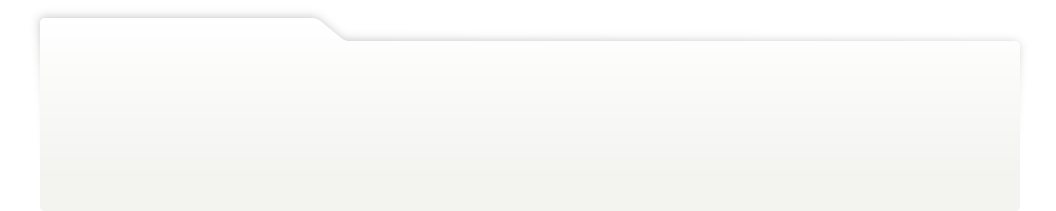
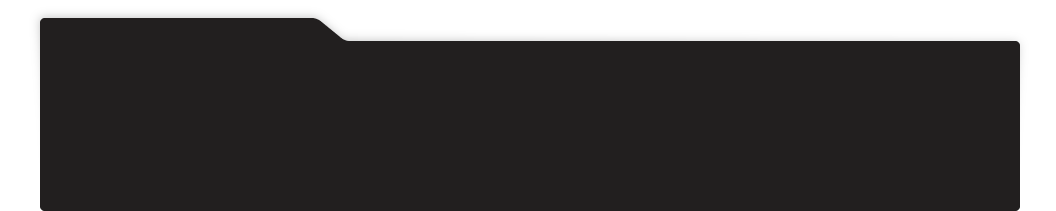
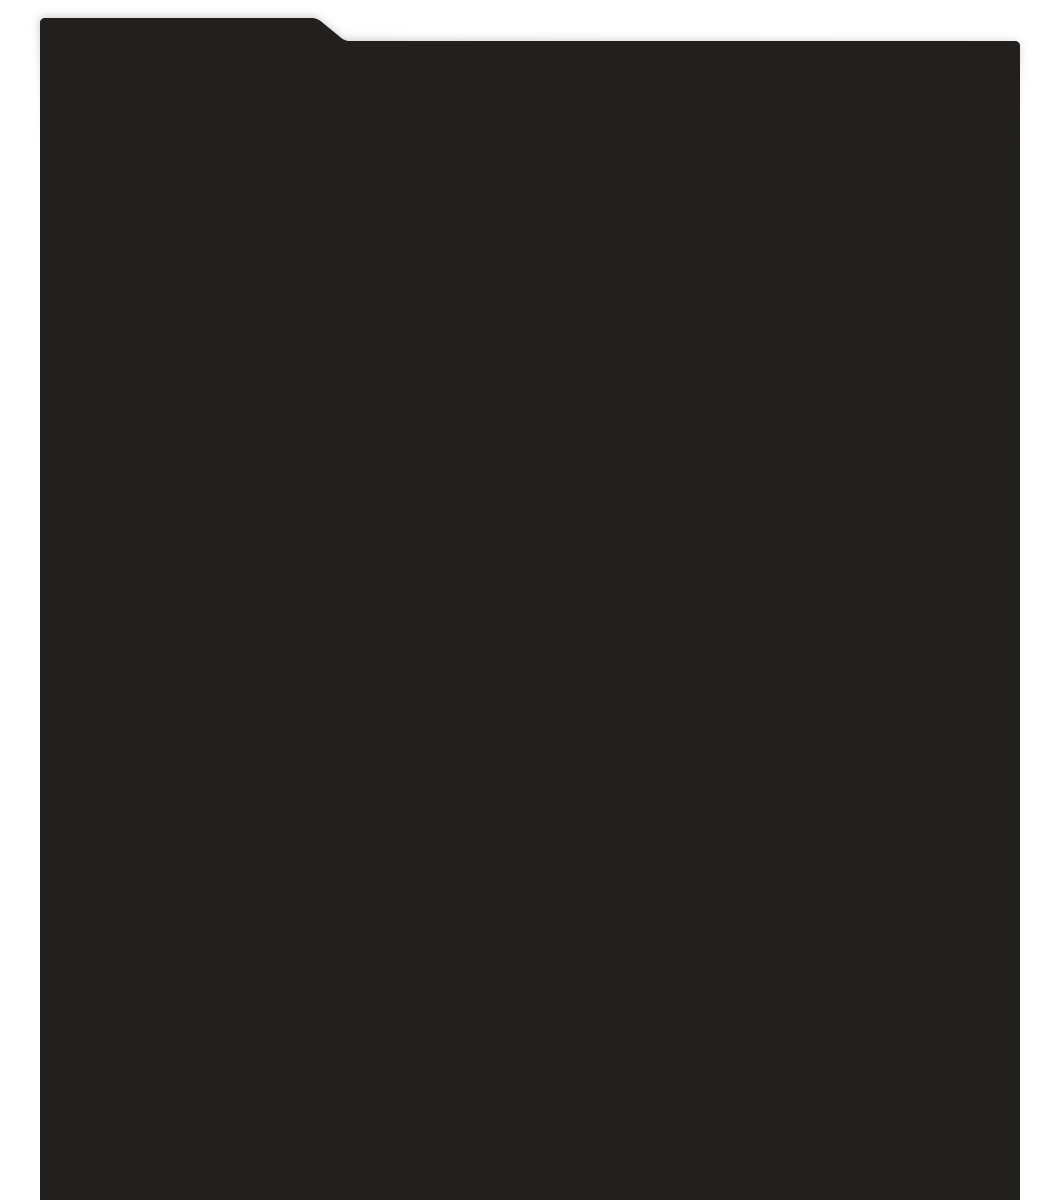
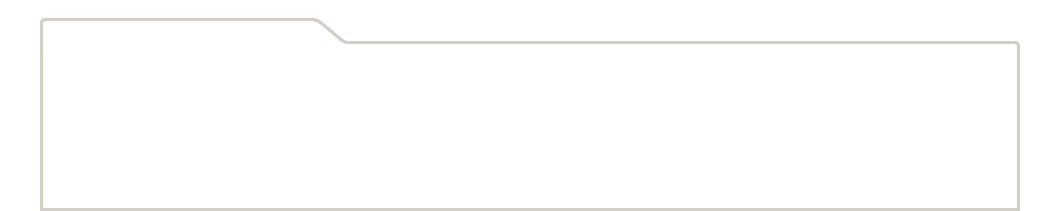
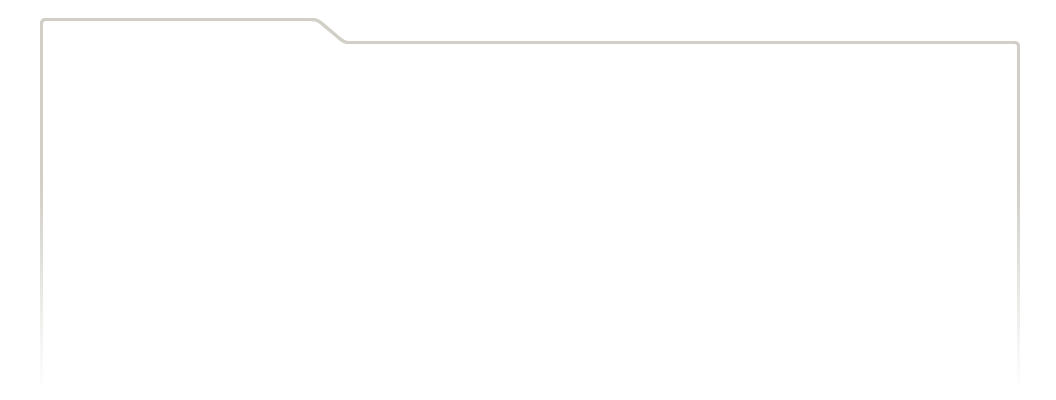
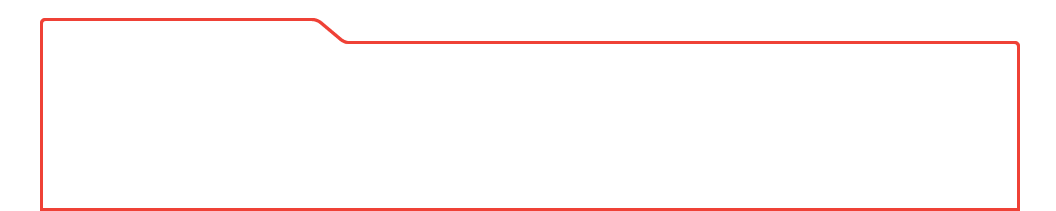
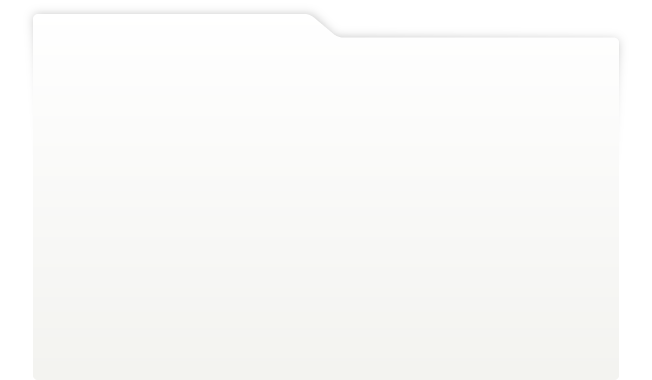
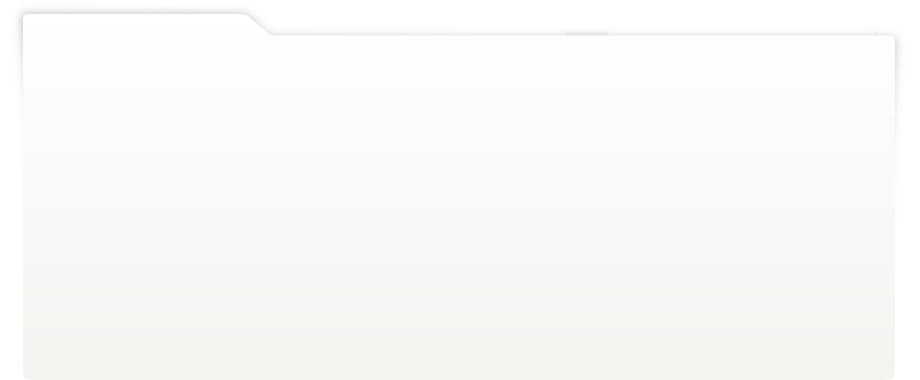
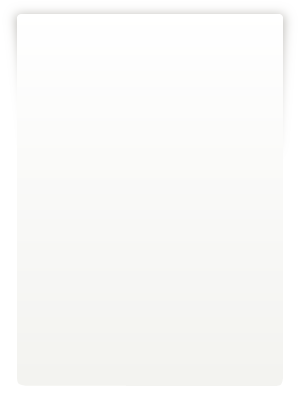
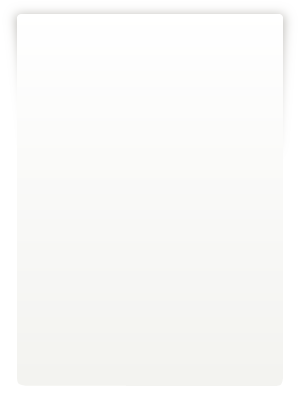
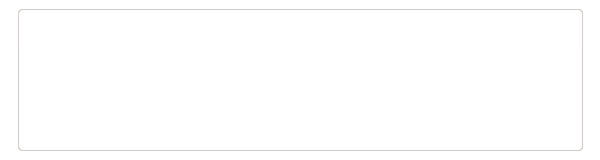
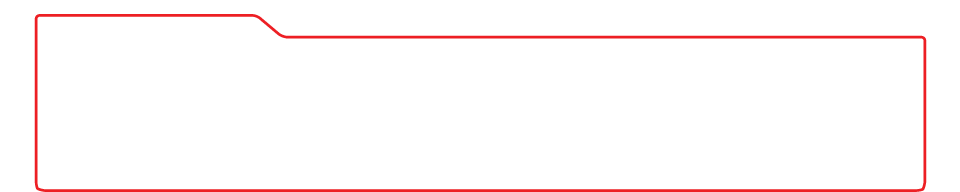
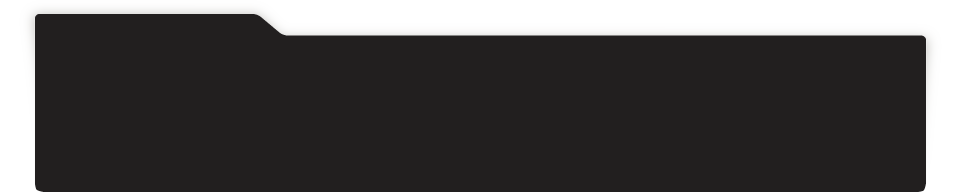
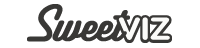
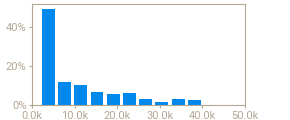
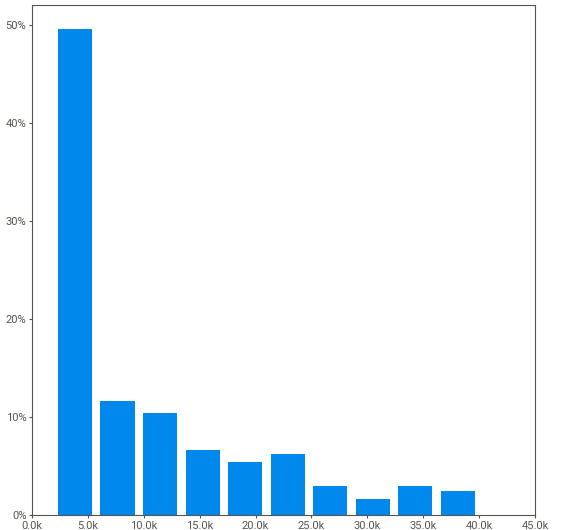
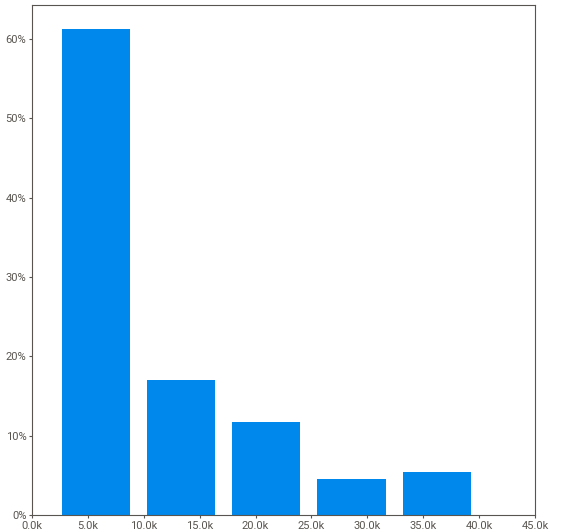
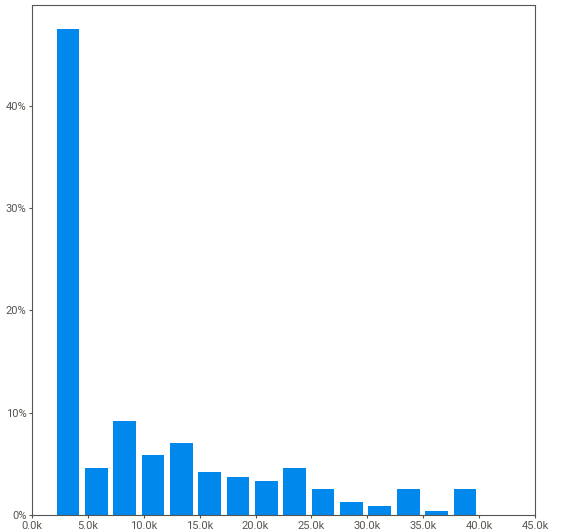
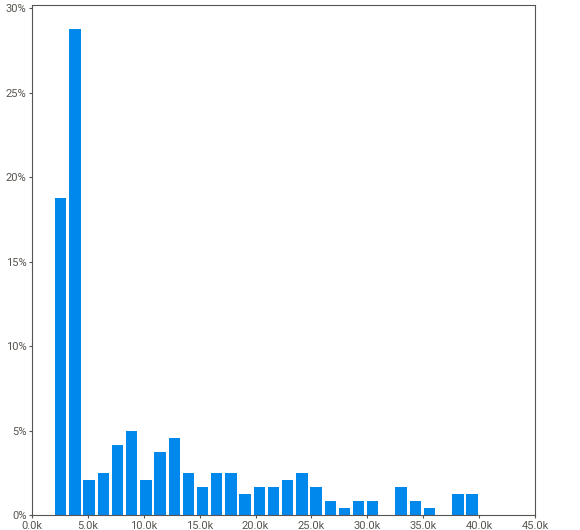
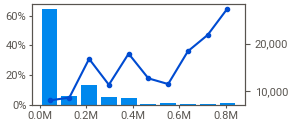
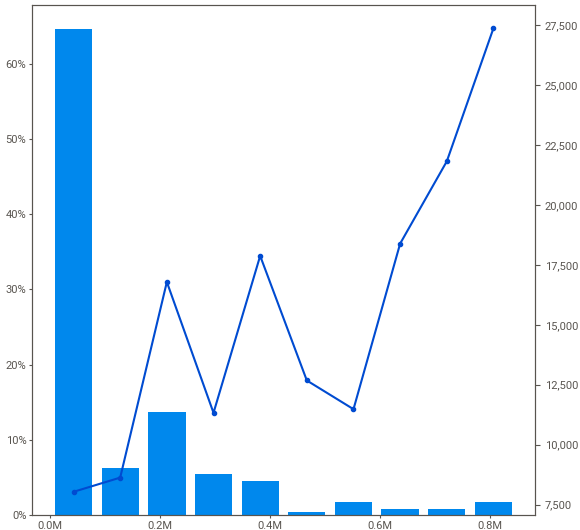
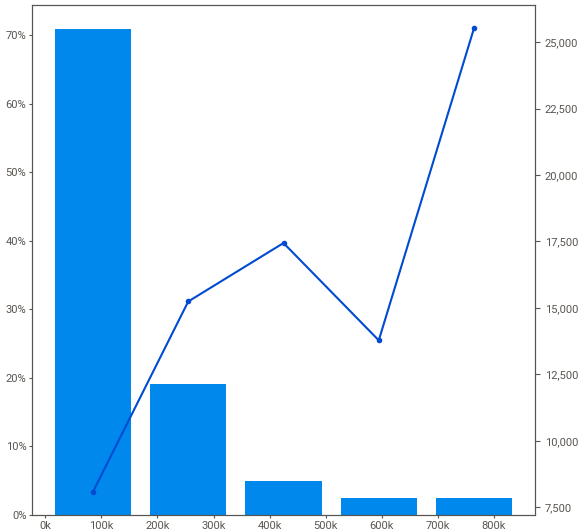
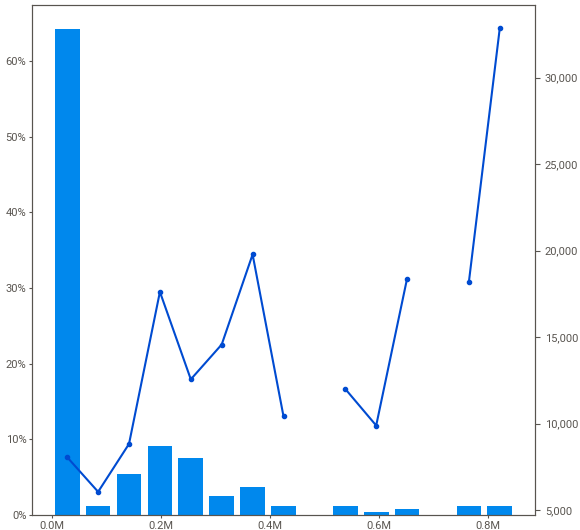
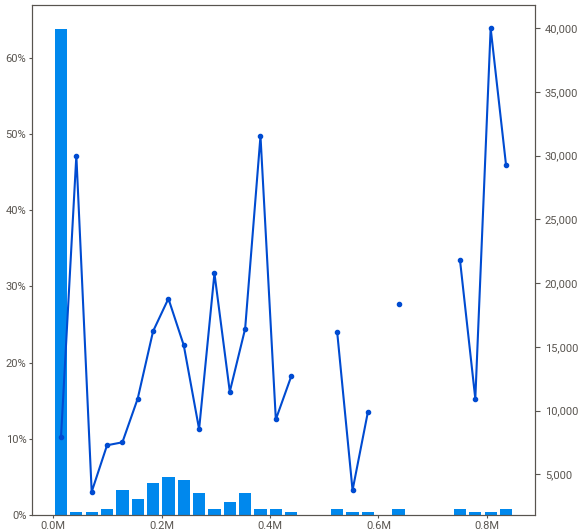
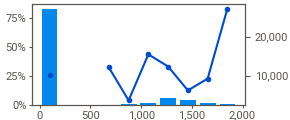
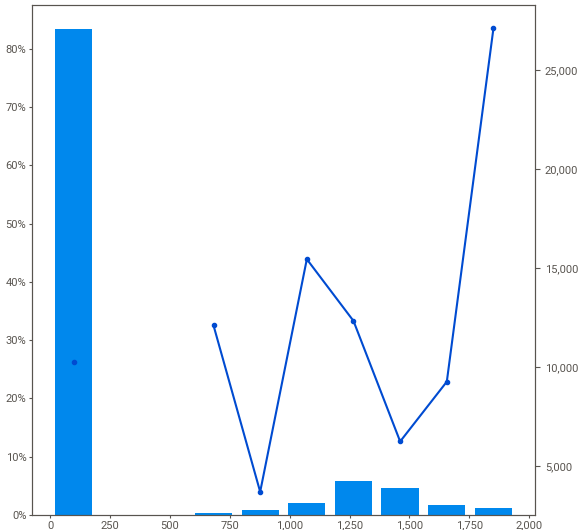
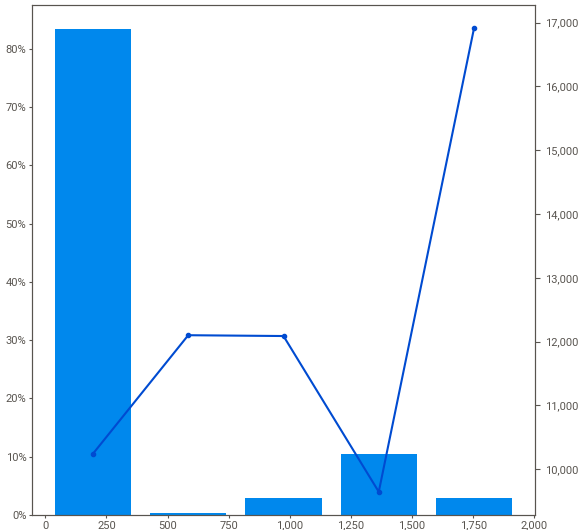
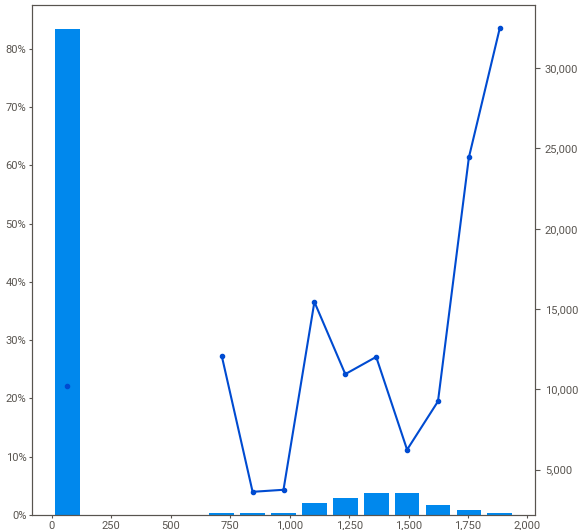
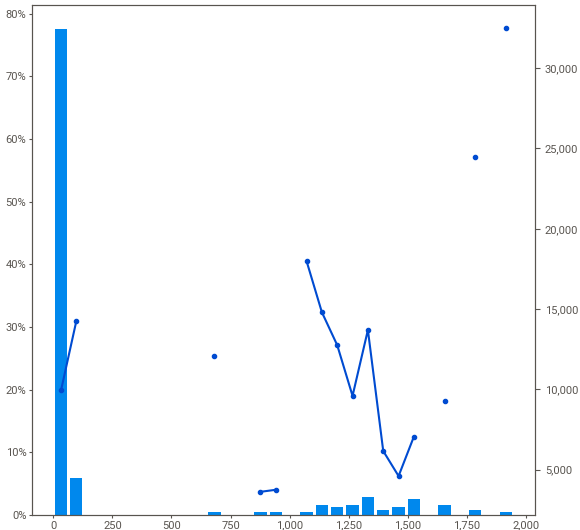
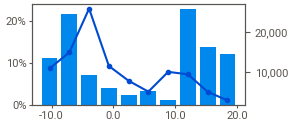
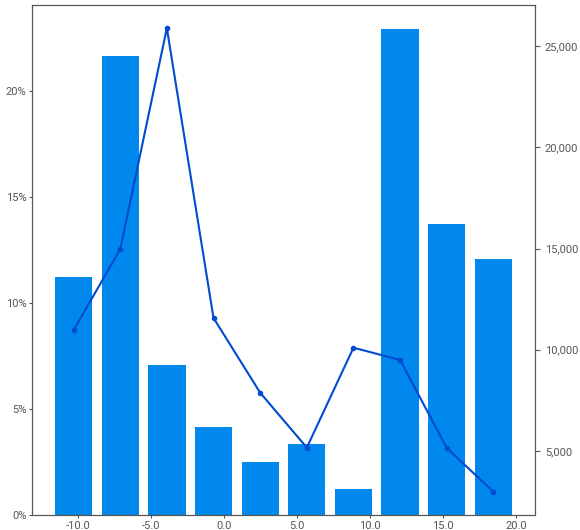
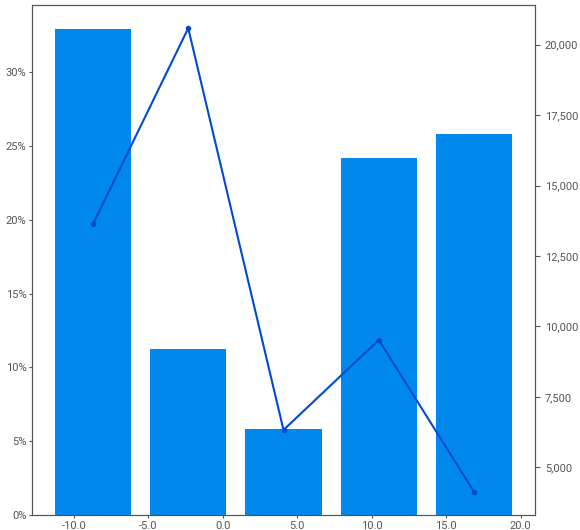
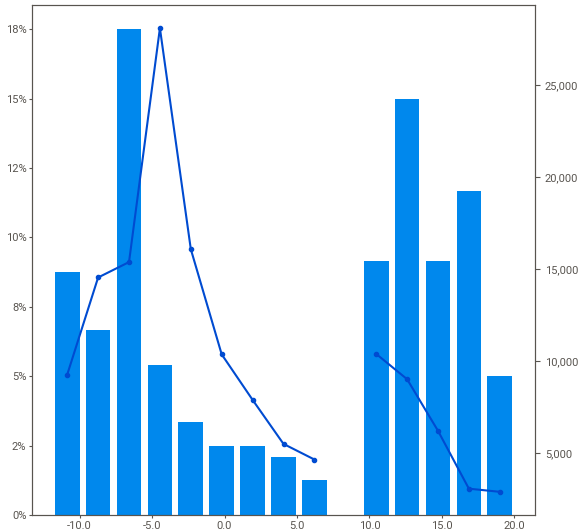
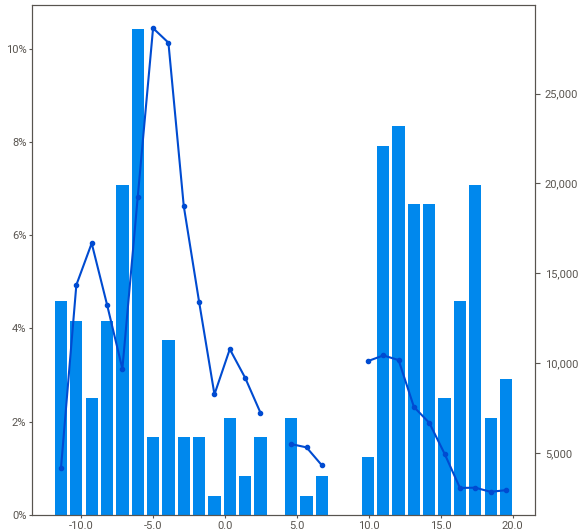
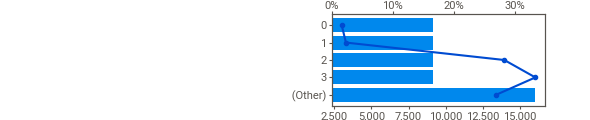
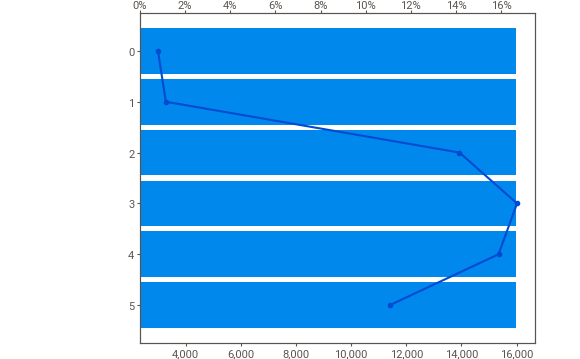
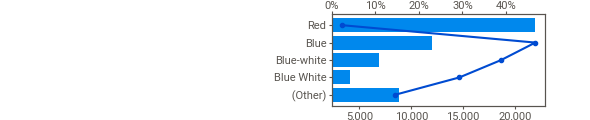
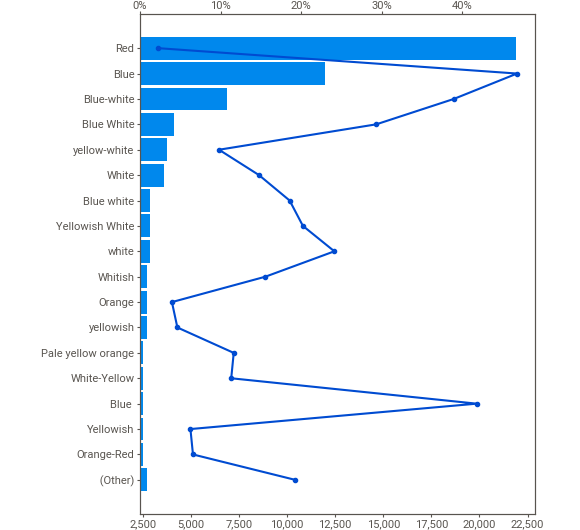
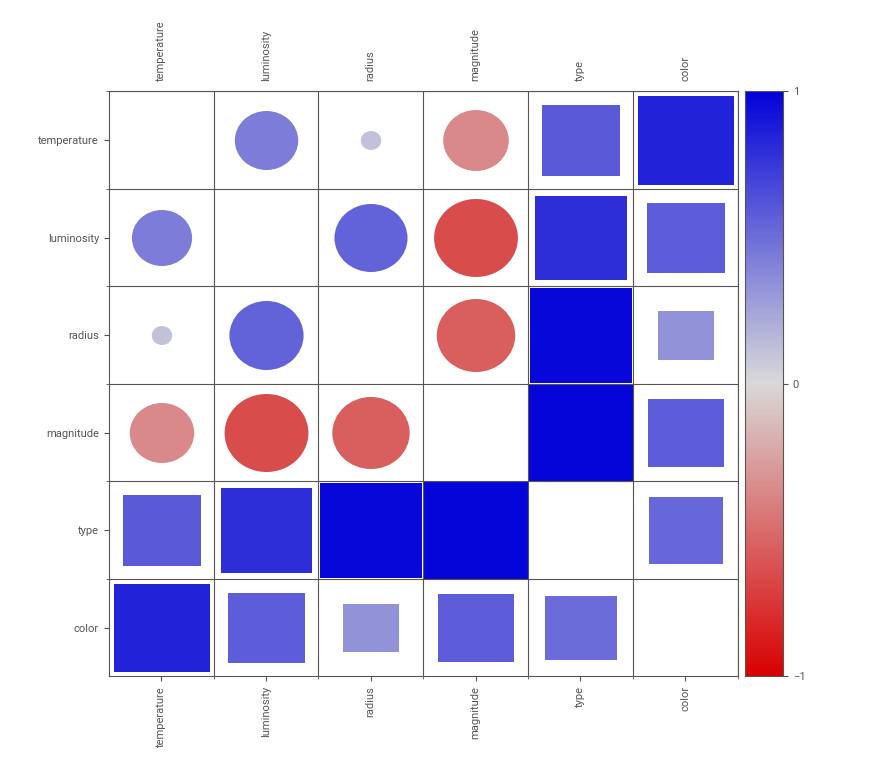
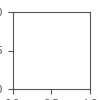

In [15]:
# use the sweetviz library for data analysis
eda_report = sv.analyze(data, target_feat='temperature')
eda_report.show_notebook(layout='vertical')

- temperature - Target value. There are no missing values. Exponential Distribution
- luminosity - Numeric variable
- radius - Numeric variable. Lots of outliers. The correlation with temperature is small.
- magnitude - The numerical variable
- type - A categorical variable. Strongly correlates with numerical variables.
- color - Categorical variable

There are many different names in the color column. Bring the same colors to the same form.

In [16]:
data['color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
Yellowish White         3
white                   3
Whitish                 2
Orange                  2
yellowish               2
Pale yellow orange      1
White-Yellow            1
Blue                    1
Yellowish               1
Orange-Red              1
Blue white              1
Blue-White              1
Name: color, dtype: int64

In [17]:
data['color'] = data['color'].str.lower()
data['color'] = data['color'].str.strip()

In [18]:
def color(x):
    if x == 'blue white':
        return 'blue-white'
    elif x in ['yellowish white','white-yellow']:
        return 'yellow-white'
    elif x == 'whitish':
        return 'white'
    elif x == 'yellowish':
        return 'yellow'
    elif x in ['pale yellow orange', 'orange-red']:
        return 'orange'
    else:
        return x

In [19]:
data['color'] = data['color'].apply(color)
data['color'].value_counts()

red             112
blue             56
blue-white       41
white            12
yellow-white     12
orange            4
yellow            3
Name: color, dtype: int64

Select the most common colors and define the rest as 'others'

In [20]:
most_frequent = ['red', 'blue', 'blue-white']
data['color'] = data['color'].apply(lambda x: 'others' if x not in most_frequent else x)

### Pre-processing

In [21]:
x_train, x_test, y_train, y_test = train_test_split(data.drop('temperature', axis=1), data['temperature'],
                                                    train_size=0.8, random_state=67, shuffle=True)

In [22]:
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, train_size=0.5, random_state=67, shuffle=True)

In [23]:
categorical = ['type', 'color']
numeric = ['luminosity', 'radius', 'magnitude']

In [24]:
col_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numeric),
        ('ohe', OneHotEncoder(sparse=False, drop='first'), categorical)],
    remainder="passthrough"
)

x_train = col_transformer.fit_transform(x_train)
x_test = col_transformer.transform(x_test)
x_valid = col_transformer.transform(x_valid)


## Building a basic neural network

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cpu


In [26]:
x_train = torch.FloatTensor(x_train).to(device)
x_valid = torch.FloatTensor(x_valid).to(device)
x_test = torch.FloatTensor(x_test).to(device)

In [27]:
y_train = torch.FloatTensor(y_train.values).reshape(y_train.shape[0], 1).to(device)
y_valid = torch.FloatTensor(y_valid.values).reshape(y_test.shape[0], 1).to(device)
y_test = torch.FloatTensor(y_test.values).reshape(y_test.shape[0], 1).to(device)

In [28]:
n_in_neurons, n_out_neurons = x_train.shape[1], 1

In [29]:
loss = nn.MSELoss()
rmse = MeanSquaredError(squared = False)

In [30]:
def learn_model(model, num_epochs, hidden_layers=1):
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        preds = model(x_train)

        loss_value = loss(preds, y_train)

        loss_value.backward()

        optimizer.step()

    model.eval()
    with torch.inference_mode():
        accuracy = rmse(model(x_valid), y_valid)
    if hidden_layers == 1:
        print(f'h1: {n_hidden_neurons_1} | rmse: {accuracy}')
    elif hidden_layers == 2:
        print(f'h1: {n_hidden_neurons_1} | h2: {n_hidden_neurons_2} | rmse: {accuracy}')
    else:
        print(f'h1: {n_hidden_neurons_1} | h2: {n_hidden_neurons_2} | h3: {n_hidden_neurons_3} | rmse: {accuracy}')

### Model with one hidden layer

In [31]:
hidden_neurons_1 = [100, 300, 500, 800, 1000, 1200, 1500, 1800, 2100, 2500]
num_epochs = 700

In [32]:
for n_hidden_neurons_1 in hidden_neurons_1:
    net = nn.Sequential(
        nn.Linear(n_in_neurons, n_hidden_neurons_1),
        nn.ReLU(),
        nn.Linear(n_hidden_neurons_1, n_out_neurons),
        nn.ReLU()
    ).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    learn_model(net, num_epochs, hidden_layers=1)

h1: 100 | rmse: 16386.861328125
h1: 300 | rmse: 15920.419921875
h1: 500 | rmse: 15488.53125
h1: 800 | rmse: 14921.5458984375
h1: 1000 | rmse: 14550.828125
h1: 1200 | rmse: 14201.712890625
h1: 1500 | rmse: 13710.2802734375
h1: 1800 | rmse: 13278.1513671875
h1: 2100 | rmse: 12849.6630859375
h1: 2500 | rmse: 12359.8427734375


The best accuracy was achieved for the NN with 2500 neurons in the hidden layer (RMSE = 12384)

### Model with two hidden layers

In [33]:
hidden_neurons_1 = list(range(300, 1500, 100))
hidden_neurons_2 = list(range(300, 1200, 100))
samples = 20

In [34]:
for i in range(samples):
    n_hidden_neurons_1 = hidden_neurons_1[np.random.randint(0, len(hidden_neurons_1))]
    n_hidden_neurons_2 = hidden_neurons_2[np.random.randint(0, len(hidden_neurons_2))]

    net = nn.Sequential(
        nn.Linear(n_in_neurons, n_hidden_neurons_1),
        nn.Tanh(),
        nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
        nn.ReLU(),
        nn.Linear(n_hidden_neurons_2, n_out_neurons)
    ).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    learn_model(net, num_epochs, hidden_layers=2)

h1: 1200 | h2: 900 | rmse: 3435.989990234375
h1: 500 | h2: 1000 | rmse: 4208.0791015625
h1: 700 | h2: 800 | rmse: 4270.7275390625
h1: 500 | h2: 1000 | rmse: 4260.201171875
h1: 600 | h2: 400 | rmse: 5529.99951171875
h1: 1400 | h2: 400 | rmse: 4120.65576171875
h1: 400 | h2: 500 | rmse: 5987.64404296875
h1: 1200 | h2: 600 | rmse: 3830.228759765625
h1: 1200 | h2: 1100 | rmse: 3402.837158203125
h1: 300 | h2: 700 | rmse: 5900.548828125
h1: 1100 | h2: 500 | rmse: 4190.35595703125
h1: 800 | h2: 300 | rmse: 5567.3076171875
h1: 700 | h2: 400 | rmse: 5407.78466796875
h1: 600 | h2: 300 | rmse: 6288.6005859375
h1: 1300 | h2: 1100 | rmse: 3419.973876953125
h1: 800 | h2: 800 | rmse: 3889.859619140625
h1: 400 | h2: 400 | rmse: 6195.3984375
h1: 300 | h2: 700 | rmse: 5739.91064453125
h1: 1400 | h2: 1000 | rmse: 3384.900146484375
h1: 1100 | h2: 600 | rmse: 4023.247314453125


The model with two hidden layers performed much better. The best RMSE more than halved to 3338, with 1100 neurons in the first hidden layer and 1100 neurons in the second hidden layer.

### Model with 3 hidden layers

In [35]:
hidden_neurons_1 = list(range(300, 800, 50))
hidden_neurons_2 = list(range(300, 800, 50))
hidden_neurons_3 = list(range(300, 600, 50))
samples = 20

In [36]:
for i in range(samples):
    n_hidden_neurons_1 = hidden_neurons_1[np.random.randint(0, len(hidden_neurons_1))]
    n_hidden_neurons_2 = hidden_neurons_2[np.random.randint(0, len(hidden_neurons_2))]
    n_hidden_neurons_3 = hidden_neurons_2[np.random.randint(0, len(hidden_neurons_3))]

    net = nn.Sequential(
        nn.Linear(n_in_neurons, n_hidden_neurons_1),
        nn.Tanh(),
        nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
        nn.Tanh(),
        nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
        nn.ReLU(),
        nn.Linear(n_hidden_neurons_3, n_out_neurons)
    ).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    learn_model(net, num_epochs, hidden_layers=3)

h1: 650 | h2: 600 | h3: 400 | rmse: 5376.61865234375
h1: 500 | h2: 650 | h3: 350 | rmse: 5310.01318359375
h1: 400 | h2: 500 | h3: 350 | rmse: 5129.49072265625
h1: 750 | h2: 350 | h3: 500 | rmse: 5495.080078125
h1: 300 | h2: 500 | h3: 500 | rmse: 5148.51611328125
h1: 300 | h2: 400 | h3: 300 | rmse: 5648.08935546875
h1: 500 | h2: 450 | h3: 400 | rmse: 5452.4248046875
h1: 700 | h2: 650 | h3: 350 | rmse: 5394.27978515625
h1: 300 | h2: 600 | h3: 550 | rmse: 5066.04052734375
h1: 650 | h2: 700 | h3: 300 | rmse: 5223.94091796875
h1: 600 | h2: 650 | h3: 300 | rmse: 5469.6884765625
h1: 500 | h2: 550 | h3: 500 | rmse: 5153.3505859375
h1: 350 | h2: 700 | h3: 350 | rmse: 5002.18115234375
h1: 300 | h2: 300 | h3: 550 | rmse: 5634.265625
h1: 300 | h2: 550 | h3: 350 | rmse: 5348.33203125
h1: 650 | h2: 700 | h3: 350 | rmse: 5094.31298828125
h1: 550 | h2: 700 | h3: 500 | rmse: 5210.658203125
h1: 300 | h2: 550 | h3: 400 | rmse: 5311.09619140625
h1: 750 | h2: 650 | h3: 300 | rmse: 5404.3955078125
h1: 700 |

NN with 3 hidden layers showed no improvement. In the final model, we will use 2 hidden layers.

In [37]:
n_hidden_neurons_1, n_hidden_neurons_2 = 1100, 1100

Determine the optimal number of epochs

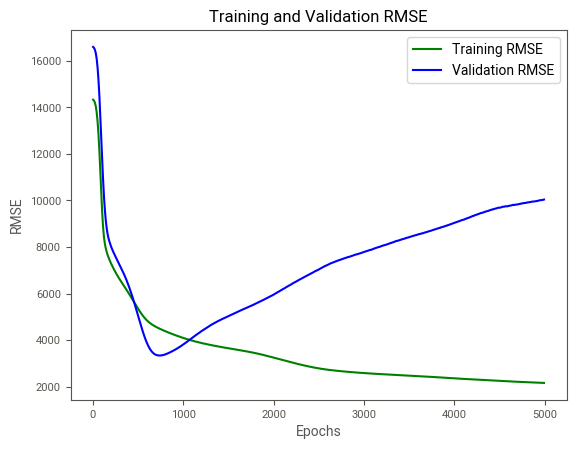

In [38]:
results_train = np.array([])
results_valid = np.array([])

model = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.Tanh(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, 5001):

    optimizer.zero_grad()

    preds = model(x_train)

    loss_value = loss(preds, y_train)

    loss_value.backward()

    optimizer.step()
    if epoch % 10 == 0:
        accuracy_train = rmse(model(x_train), y_train)
        results_train = np.append(results_train, accuracy_train.cpu().detach().numpy())

        accuracy = rmse(model(x_valid), y_valid)
        results_valid = np.append(results_valid, accuracy.cpu().detach().numpy())
epochs = np.arange(1, 5001, 10)
plt.plot(epochs, results_train, 'g', label='Training RMSE')
plt.plot(epochs, results_valid, 'b', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

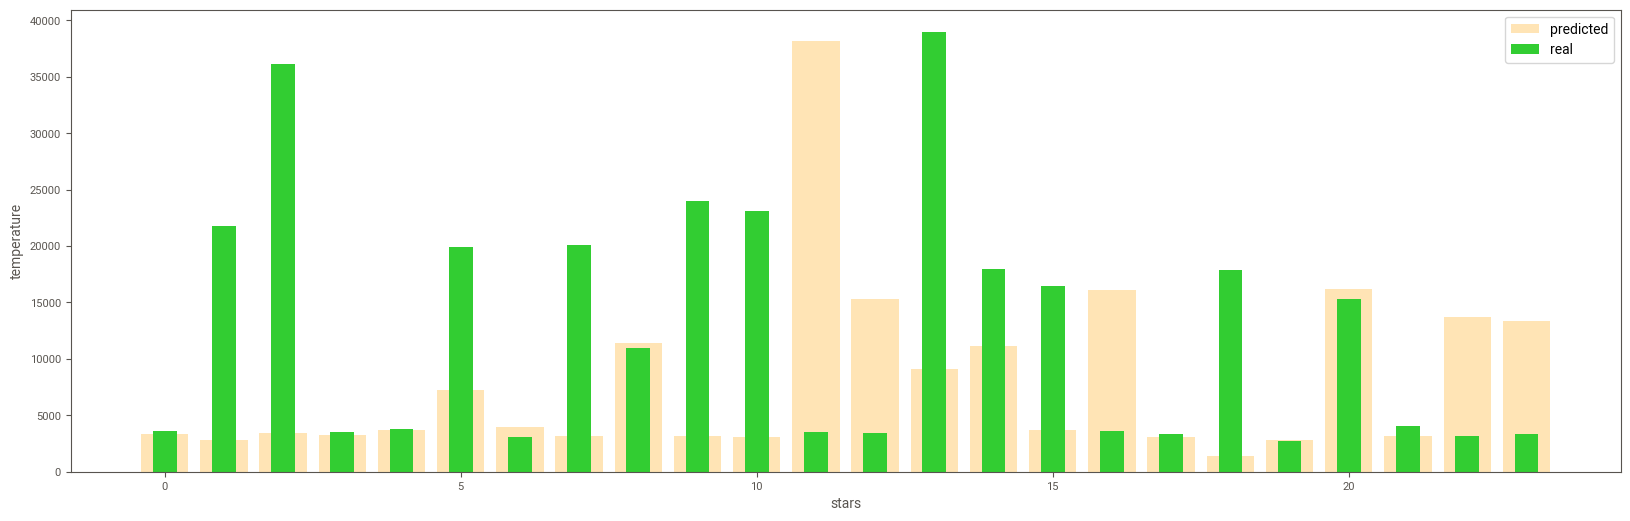

In [39]:
predictions = model(x_test)

valid_preds = pd.DataFrame(predictions.cpu().detach().numpy(), columns=['temperature'])
valid_target = pd.DataFrame(y_valid.cpu().detach().numpy(), columns=['temperature'])
fig, ax = plt.subplots(figsize=[20, 6])
plt.bar(x=valid_preds.index, height=valid_preds['temperature'], color='moccasin', label='predicted')
plt.bar(x=valid_target.index, height=valid_target['temperature'], color='limegreen', label='real', width=0.4)
plt.xlabel('stars')
plt.ylabel('temperature')
ax.legend()
plt.show()

## Neural Network Improvement

### Add division into batches to the NN training and select the optimal size

In [40]:
batch_values = [x_train.shape[0], 100, 80, 60, 50, 40, 30, 25]

In [41]:
for batch_size in batch_values:

    model = nn.Sequential(
        nn.Linear(n_in_neurons, n_hidden_neurons_1),
        nn.Tanh(),
        nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
        nn.ReLU(),
        nn.Linear(n_hidden_neurons_2, n_out_neurons)
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    num_batches = ceil(len(x_train)/batch_size)

    for epoch in range(num_epochs):

        order = np.random.permutation(len(x_train))

        for batch_idx in range(num_batches):

            start_index = batch_idx * batch_size
            optimizer.zero_grad()

            batch_indexes = order[start_index:start_index+batch_size]
            x_batch = x_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = model(x_batch)
            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()

    model.eval()
    with torch.inference_mode():
        accuracy = rmse(model(x_valid), y_valid)

    print(f'batch_size: {batch_size}, rmse: {accuracy}')

batch_size: 192, rmse: 3431.346435546875
batch_size: 100, rmse: 3778.866943359375
batch_size: 80, rmse: 4263.85546875
batch_size: 60, rmse: 4599.94873046875
batch_size: 50, rmse: 4633.259765625
batch_size: 40, rmse: 4814.95751953125
batch_size: 30, rmse: 5056.53564453125
batch_size: 25, rmse: 5206.74609375


Batch training proved to be worse.

### Add Dropout to NN

In [42]:
dropout = [0.3, 0.5, 0.7, 0.8]

In [43]:
for i in dropout:
    for j in dropout:
        net = nn.Sequential(
            nn.Linear(n_in_neurons, n_hidden_neurons_1),
            nn.Tanh(),
            nn.Dropout(i),
            nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
            nn.ReLU(),
            nn.Dropout(j),
            nn.Linear(n_hidden_neurons_2, n_out_neurons)
            ).to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
        print(i, j)
        learn_model(net, num_epochs, hidden_layers=2)

0.3 0.3
h1: 1100 | h2: 1100 | rmse: 3916.3720703125
0.3 0.5
h1: 1100 | h2: 1100 | rmse: 3937.911865234375
0.3 0.7
h1: 1100 | h2: 1100 | rmse: 4041.1650390625
0.3 0.8
h1: 1100 | h2: 1100 | rmse: 4176.86376953125
0.5 0.3
h1: 1100 | h2: 1100 | rmse: 4310.08837890625
0.5 0.5
h1: 1100 | h2: 1100 | rmse: 4365.6455078125
0.5 0.7
h1: 1100 | h2: 1100 | rmse: 4500.68505859375
0.5 0.8
h1: 1100 | h2: 1100 | rmse: 4582.85498046875
0.7 0.3
h1: 1100 | h2: 1100 | rmse: 4824.08349609375
0.7 0.5
h1: 1100 | h2: 1100 | rmse: 4779.3212890625
0.7 0.7
h1: 1100 | h2: 1100 | rmse: 4958.0439453125
0.7 0.8
h1: 1100 | h2: 1100 | rmse: 5123.86279296875
0.8 0.3
h1: 1100 | h2: 1100 | rmse: 5045.3115234375
0.8 0.5
h1: 1100 | h2: 1100 | rmse: 5153.40625
0.8 0.7
h1: 1100 | h2: 1100 | rmse: 5317.55810546875
0.8 0.8
h1: 1100 | h2: 1100 | rmse: 5526.19873046875


NN training proved to be worse.

## Result

In [44]:
model = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.Tanh(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(700):

    optimizer.zero_grad()

    preds = model(x_train)

    loss_value = loss(preds, y_train)

    loss_value.backward()

    optimizer.step()

model.eval()
with torch.inference_mode():
    predictions = model(x_test)
print('best RMSE:',rmse(predictions, y_test).item())

best RMSE: 2778.927490234375


In [45]:
test_preds = pd.DataFrame(predictions.cpu().detach().numpy(), columns=['temperature'])
test_target = pd.DataFrame(y_test.cpu().detach().numpy(), columns=['temperature'])

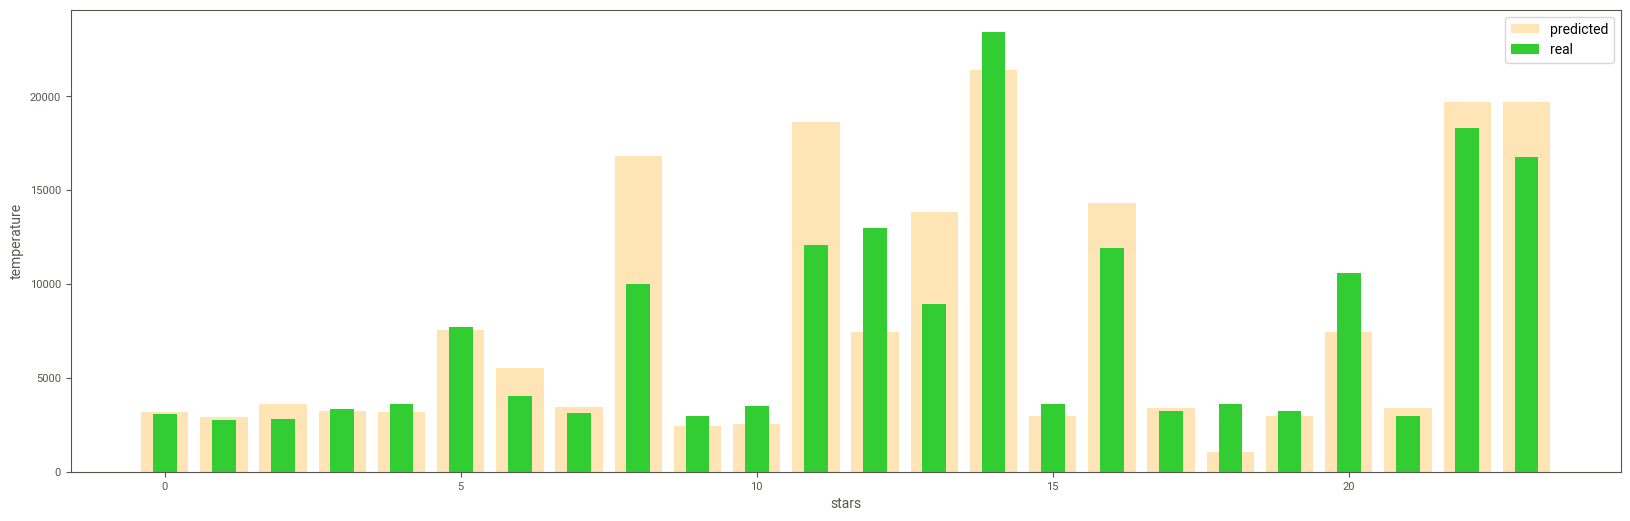

In [46]:
fig, ax = plt.subplots(figsize=[20,6])
plt.bar(x=test_preds.index, height=test_preds['temperature'], color='moccasin' , label='predicted')
plt.bar(x=test_target.index, height=test_target['temperature'], color='limegreen', label='real', width= 0.4)
plt.xlabel('stars')
plt.ylabel('temperature')
ax.legend()
plt.show()

## Conclusions

The neural network with two hidden layers (1100 and 1100 neurons) trained in 700 epochs showed itself to be the best.

RMSE = 2801

The model accurately predicts temperatures up to 5000K.